# Modeling Zinc modulation of NMDAR signaling

Model ingredients:

- Zinc inhibits NMDAR via a high-affinity binding mechanism
- NMDAR has its classical voltage dependency 
- Zinc inhibition is concentration dependent (with a half activation value in the nanomolar range) and voltage-independent
- Zinc is stored in synaptic vesicles and co-released with glutamate
- Zinc concentration in the synaptic cleft follows a release/re-uptake dynamics
- Zinc effect on NMDAR has a binding/unbinding dynamics

## Modeling Zinc modulation in a single compartment

In a single compartment model containing AMPA, NMDA and GABA synaptic currents, the membrane equation reads:

\begin{equation}
\label{eq:membrane-eq-single-comp}
\begin{split}
C_m \frac{dV_m}{dt} = & g_L \, \big(E_L - V_m \big) \\
                      + & g_{NMDA}(V_m, c_{Zn}, t) \, (E_{NMDA}-V_m) \\
                      + & g_{AMPA}(t)  \, (E_{AMPA}-V_m) \\
                      + & g_{GABA}(t)  \, (E_{GABA}-V_m)
\end{split}
\end{equation}

The AMPA and GABA synaptic currents depend on the conductances ($g_{AMPA}$ and $g_{GABA}$ respectively), they are voltage independent, their temporal dynamics are only constrained by the integration of synaptic events, i.e. they and follow the equations:

\begin{equation}
g_{AMPA}(t) =  Q_{AMPA} \, \sum_{\{t^{k}\}_{glut}} \mathcal{H}(t-t^k) \cdot B(t-t^k, \tau_{AMPA}^{rise}, \tau_{AMPA}^{decay})
\end{equation}

\begin{equation}
g_{GABA}(t) =  Q_{GABA} \, \sum_{\{t^{k}\}_{GABA}} \mathcal{H}(t-t^k) \cdot  B(t-t^k, \tau_{GABA}^{rise}, \tau_{GABA}^{decay})
\end{equation}

where:
\begin{equation}
B (t, \tau_1, \tau_2) = \frac{(\tau_2/\tau_1)^{\frac{\tau_2}{\tau_2-\tau_1}}}{\tau_2/\tau_1 -1 } \Big( e^{-t/\tau_2} - e^{-t/\tau_1} \Big)
\end{equation}
is the normalized double exponential function (peaking to 1 at maximum), where $Q_{AMPA}$ and $Q_{GABA}$ are the quantals of conductance increments at their respective events, and where $\{t^{k}\}_{glut}$ and $\{t^{k}\}_{GABA}$ are respectively the sets of glutamatergic and GABAergic presynaptic events.

In addition to its dependency on the set of glutamatergic synaptic events, the NMDA conductance has both a dependency on membrane depolarization ($V_m$) and on the Zinc-concentration ($c_{Zn}$), its equation is:

\begin{equation}
g_{NMDA}(V_m, c_{Zn}, t) = N(V_m) \cdot \big(1 - \alpha_{Zn} \, F(c_{Zn}) \big) \cdot Q_{NMDA} \, \sum_{\{t^{k}\}_{glut}}  \mathcal{H}(t-t^k) \cdot B(t-t^k, \tau_{NMDA}^{rise}, \tau_{NMDA}^{decay})
\end{equation}

where $N(V_m)$ is the classical voltage-dependency of NMDA channels due to the Magnesium block described by (Farinella et al., 2014):

\begin{equation}
N(V_m) = \frac{1}{0.3+e^{- 80 * V_m} }
\end{equation}

where $\alpha_{Zn}$ is the fraction of inactivated NMDA channel at maximum inactivation (i.e. at high Zinc concentration), where $Q_{NMDA}$ is the quantal of (maximum) conductance increment and where $F(c_{Zn})$ is the relation between "effective" Zinc concentration and NMDA inactivation, this inactivation function is determined by the error function:

\begin{equation}
F(c_{Zn}) = (1+ Erf\big( \frac{c-c^0_{Zn}}{\delta c_{Zn}} \big))/2
\end{equation}

The temporal evolution of the "effective" Zinc concentration in the synaptic cleft is also determined by the set of glutametargic events with:
\begin{equation}
c_{Zn}(t) = Q_{Zn} \, \sum_{\{t^{k}\}_{glut}} \mathcal{H}(t-t^k) \cdot B(t-t^k, \tau_{Zn}^{rise}, \tau_{Zn}^{decay})
\end{equation}

----------------------------------------------

$Zn^{2+}$ chelation is modelled by $Q_{Zn}=0$ (the glutamate release does not lead to any increase of the "effective" Znc concentration), 

it could also be modelled by $\alpha_{Zn}$=0 (the variations of Zinc concentrations do not have any effect)

----------------------------------------------

TO BE DISCUSSED / SHAKY ASPECTS

- the Binding/Unbinding dynamics and the Release/Re-uptake dynamics are merged into a single "effective" Zinc dynamics for simplicity

- the Zinc concentration is a linear variable spanning [0,100nM], we could have it logarhitmically spanning [1nM, 1uM]


## Parameters

In [302]:
# all parameters in SI units ! (i.e. volts, amps, siemens, seconds, ...)

params = {
    # passive cellular properties
    'Cm':200e-12, # farad
    'gL':10e-9, # siemens
    'El':-70e-3, # volt
    # GABA
    'Trise_GABA':0.5e-3, # second
    'Tdecay_GABA':5e-3,
    'Q_GABA':1e-9,
    'Erev_GABA':-80e-3,
    # AMPA
    'Trise_AMPA':0.5e-3,
    'Tdecay_AMPA':5e-3,
    'Q_AMPA':1e-9,
    'Erev_AMPA':0e-3,
    # NMDA
    'NMDA-to-AMPA-ratio':0.8,
    'Trise_NMDA':7e-3,
    'Tdecay_NMDA':70e-3,
    'Q_NMDA':0.8e-9, # i.e. from 'NMDA-to-AMPA-ratio':0.8,
    'Erev_NMDA':0e-3,
    # Vm-modul NMDA
    'V0_NMDA':1./0.08,
    # Zn-modul NMDA
    'Q_Zn':5e-9, # increment of effective Zn concentration
    'C0_Zn':20e-9,
    'deltaC_Zn':10e-9,
    'Trise_Zn':50e-3,
    'Tdecay_Zn':3.,
    'alpha_Zn':0.4, # fraction of inactivated conductance at peak 
}

params_no_Zn = params.copy() 
params_no_Zn['Q_Zn'] = 0

## Numerical implementation

In [303]:
import numpy as np
from scipy.special import erf

def inactivation_function(c, c0=0., dc=1.):
    """
    inactivation function derived from error function
    """
    return (erf((c-c0)/dc)+1.)/2.

def double_exponential(t, T1, T2):
    """
    double exponential function normalized to peak level
    """
    return (np.exp(-t/T2)-np.exp(-t/T1))/(T2/T1-1)*((T2/T1)**(T2/(T2-T1)))


def compute_time_variations_from_events(SET_OF_EVENTS,
                                        t,
                                        Trise=1e-3, Tdecay=10e-3, quantal=1.):
    """
    integration of synaptic events to shape the synaptic conductance
    (convolution with double exponential over synaptic events)
    """
    conductance = 0*t # initialized to 0

    dt = t[1]-t[0]
    ilength = int(5*(Tdecay+Trise)/dt) # for each even we 
    event_waveform = quantal*double_exponential(t[:ilength]-t[0], Trise, Tdecay)
    
    for event in SET_OF_EVENTS:
        i0 = np.argmin((t-event)**2) # find the time point where the event falls
        conductance[i0:min([i0+ilength,len(t)])] += event_waveform[:min([ilength,len(t)-i0])]
        
    return conductance


def voltage_dep_NMDA(x):
    """
    x should be in volts !!
    
    taken from Farinella et al. (2014)
    """
    return 1./(0.3+np.exp(-1e3*x*0.08))


def plot_temporal_dynamics(simulation, ge):
    """
    a general plotting function to visualize the result of a simulation 
        over the different variables of the model
    """
    fig, AX = ge.figure(axes_extents=[[[3,2]],[[3,1]],[[3,1]],[[3,1]],[[3,1]]], figsize=(1.3,.5))

    if simulation['result_type']=='current-clamp':
        AX[0].plot(1e3*simulation['t'], 1e3*simulation['Vm'], 'k-')
        ylabel1 = '$V_m$ (mV)'
    elif simulation['result_type']=='voltage-clamp':
        AX[0].plot(1e3*simulation['t'], 1e12*simulation['Itot'], 'k-')
        ylabel1 = '$I_{tot}$ (pA)'
       
    AX[1].plot(1e3*simulation['t'], 1e9*simulation['gGABA'], color=ge.red)
    AX[2].plot(1e3*simulation['t'], 1e9*simulation['gAMPA'], color=ge.green)
    AX[3].plot(1e3*simulation['t'], 1e9*simulation['gNMDA'], color=ge.blue)
    AX[4].plot(1e3*simulation['t'], 1e9*simulation['cZn'], color=ge.purple)
    for ax, label, i in zip(np.array(AX).flatten(),\
          [ylabel1, '$g_{GABA}$ (nS)', '$g_{AMPA}$ (nS)', '$g_{NMDA}$ (nS)', '$c_{Zn}$ (nM)'],
                           range(5)):
        ge.set_plot(ax, ['left', 'bottom'][:int(i/4)+1], ylabel=label,
                    xlim=[1e3*simulation['t'][0], 1e3*simulation['t'][-1]])
    AX[4].set_xlabel('time (ms)')
    
    return fig, AX


def solve_membrane_equation(t, params,
                            Glut_events=[],
                            GABA_events=[],
                            Vm=None,
                            result_type='current-clamp'):
    """
    solve the membrane equation
    2 result type:
        --> current-clamp
        --> voltage-clamp: the Vm array should have the clamp values (no Rs considered)
    """
        
    dt = t[1]-t[0]
    sim = {'t':t, 'result_type':result_type} # we store all results into a python dictionary

    sim['gGABA'] = compute_time_variations_from_events(GABA_events, t,
                        Trise=params['Trise_GABA'], Tdecay=params['Tdecay_GABA'], quantal=params['Q_GABA'])
    sim['gAMPA'] = compute_time_variations_from_events(Glut_events, t,
                        Trise=params['Trise_AMPA'], Tdecay=params['Tdecay_AMPA'], quantal=params['Q_AMPA'])
    sim['cZn'] = compute_time_variations_from_events(Glut_events, t,
                        Trise=params['Trise_Zn'], Tdecay=params['Tdecay_Zn'], quantal=params['Q_Zn'])
    
    # NMDA before voltage-dependency and Zinc modulation
    gNMDA = compute_time_variations_from_events(Glut_events, t,
                    Trise=params['Trise_NMDA'], Tdecay=params['Tdecay_NMDA'], quantal=params['Q_NMDA'])
    # modulation function:    
    def NMDA_modulation(Vm, cZn):
        return voltage_dep_NMDA(Vm)*\
            (1-params['alpha_Zn']*inactivation_function(cZn,
                                                        c0=params['C0_Zn'], dc=params['deltaC_Zn']))
    
    def Itot(Vm, gA, gB, gN, cZn):
        return params['gL']*(params['El']-Vm)+\
               gA*(params['Erev_AMPA']-Vm)+\
               NMDA_modulation(Vm,cZn)*gN*(params['Erev_NMDA']-Vm)+\
               gB*(params['Erev_GABA']-Vm)
    
    # initialize Vm (if not already provided as an array in the argument)
    if Vm is None:
        Vm = 0*t+params['El'] # initialize to rest 
    elif type(Vm) is float:
        Vm = 0*t+Vm
    
    if result_type=='current-clamp':
        # need to solve the membrane equation with an euler method
        for i in range(len(t)-1):
            Vm[i+1] = Vm[i]+dt/params['Cm']*Itot(Vm[i],
                                                 sim['gAMPA'][i], sim['gGABA'][i], gNMDA[i], sim['cZn'][i])
    elif result_type=='voltage-clamp':
        # nothing to do, we just return the total current over time given the voltage array
        pass
    else:
        print('Result type need to be set to either voltage-clamp or dynamic clamp')
        
    sim['Vm'] = Vm
    sim['Itot'] = -Itot(Vm, sim['gAMPA'], sim['gGABA'], gNMDA, sim['cZn']) # sign reversed (amplifier convention)
    sim['gNMDA'] = NMDA_modulation(Vm,sim['cZn'])*gNMDA

    return sim

## Checking the numerical implementation

In [304]:
from datavyz.main import graph_env
ge = graph_env('notebook')
#plot_temporal_dynamics({}, ge);

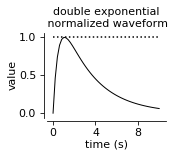

In [305]:
# double exponential waveform
t = np.linspace(0,10)
_, ax = ge.plot(t, double_exponential(t, .5, 3.), title='double exponential\n normalized waveform',
        axes_args=dict(xlabel='time (s)', ylabel='value', yticks=[0,0.5,1]));
ax.plot(t, np.ones(len(t)), 'k:')

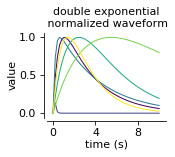

In [306]:
# showing the normalization
_, ax = ge.plot(t,
                Y=[double_exponential(t, .5, 3.),
                   double_exponential(t, .001, .1),
                   double_exponential(t, .2, 4.),
                   double_exponential(t, 3, 2),
                   double_exponential(t, 5, 6.),
                   double_exponential(t, 1, 2)],
                title='double exponential\n normalized waveform',
                axes_args=dict(xlabel='time (s)', ylabel='value', yticks=[0,0.5,1]));

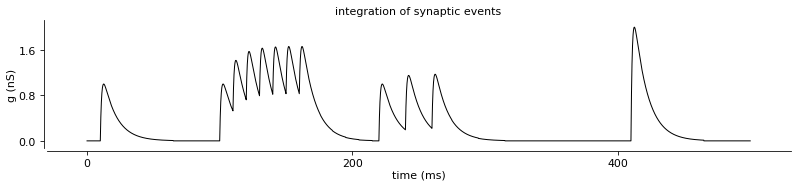

In [307]:
# conductance traces with time parameters
dt, tstop = 0.1, 500 # in ms
t = np.arange(int(tstop/dt))*dt

# generated by a set of events:
SET_OF_EVENTS = [10, 100, 110, 120, 130, 140, 150, 160, 220, 240, 260, 410, 410] # ms, N.B. double events !
conductance = compute_time_variations_from_events(SET_OF_EVENTS, t,
                                              Trise=1, Tdecay=10, # also in ms
                                              quantal=1.) # 1nS peak increment at each event 

ge.plot(t, conductance,
        title='integration of synaptic events', fig_args={'figsize':(2.5,1.5)},
        axes_args=dict(xlabel='time (ms)', ylabel='g (nS)'));

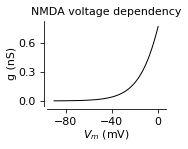

In [308]:
# Voltage dependency of NMDA current

Vm= np.linspace(-90e-3,0e-3,100) 

fig, ax = ge.plot(1e3*Vm, voltage_dep(Vm),
                    title='NMDA voltage dependency')
ge.set_plot(ax, xlabel='$V_m$ (mV)', ylabel='g (nS)')

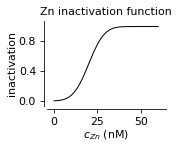

In [309]:
# Inactivation function of Zinc effect

c = np.linspace(0,60e-9)

fig, ax = ge.plot(1e9*c, inactivation_function(c, c0=params['C0_Zn'], dc=params['deltaC_Zn']),
                    title='Zn inactivation function')
ge.set_plot(ax, xlabel='$c_{Zn}$ (nM)', ylabel='inactivation')

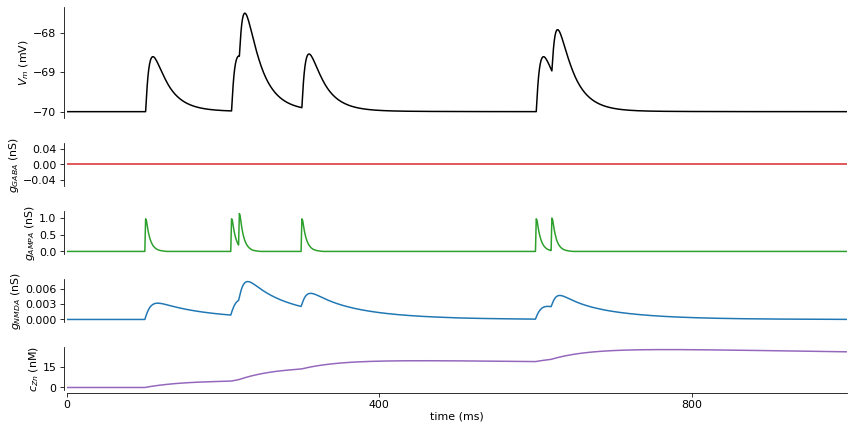

In [310]:
# temporal dynamics of the model current clamp

sim = solve_membrane_equation(np.arange(1000)*1e-3, params,
                              Glut_events=[0.1, 0.21, 0.22, 0.3, 0.6, 0.62],
                              result_type='current-clamp')
plot_temporal_dynamics(sim, ge);

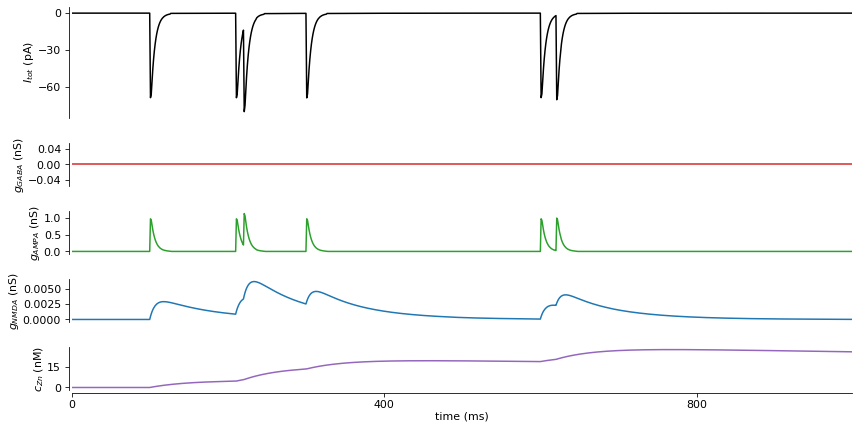

In [311]:
# same events in voltage-clamp -> hyperpolarized
sim = solve_membrane_equation(np.arange(1000)*1e-3, params,
                              Glut_events=[0.1, 0.21, 0.22, 0.3, 0.6, 0.62],
                              Vm = -70e-3,
                              result_type='voltage-clamp')
plot_temporal_dynamics(sim, ge);

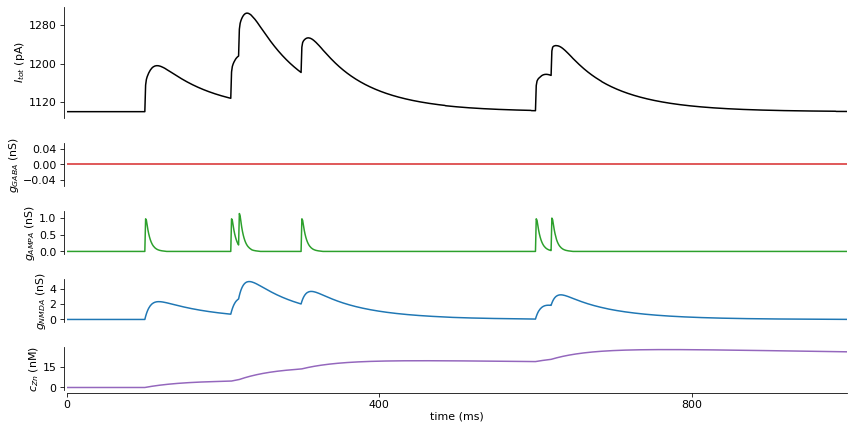

In [328]:
# same events in voltage-clamp -> highly depolarized (+40 mV)
sim = solve_membrane_equation(np.arange(1000)*1e-3, params,
                              Glut_events=[0.1, 0.21, 0.22, 0.3, 0.6, 0.62],
                              Vm = + 40e-3,
                              result_type='voltage-clamp')
plot_temporal_dynamics(sim, ge);

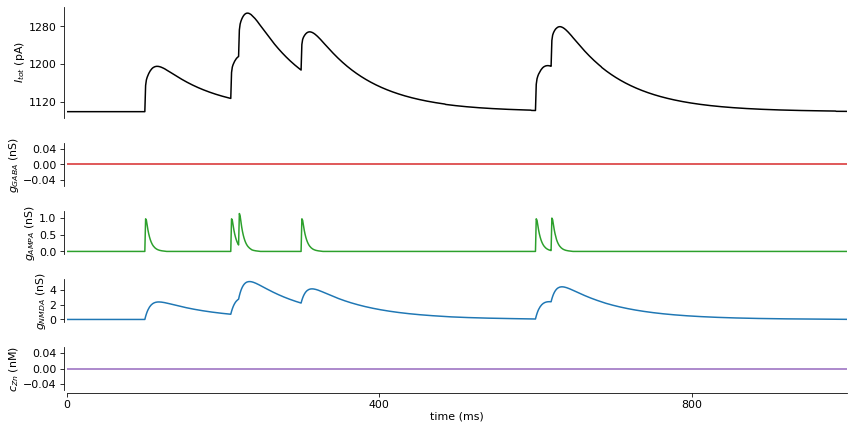

In [329]:
# same events in voltage-clamp -> highly depolarized (+40 mV)
sim_no_Zn = solve_membrane_equation(np.arange(1000)*1e-3, params_no_Zn,
                              Glut_events=[0.1, 0.21, 0.22, 0.3, 0.6, 0.62],
                              Vm = + 40e-3,
                              result_type='voltage-clamp')
plot_temporal_dynamics(sim_no_Zn, ge); # note the increase of the last events

## Response to pulse trains

(<Figure size 999.213x391.181 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f34d3513450>)

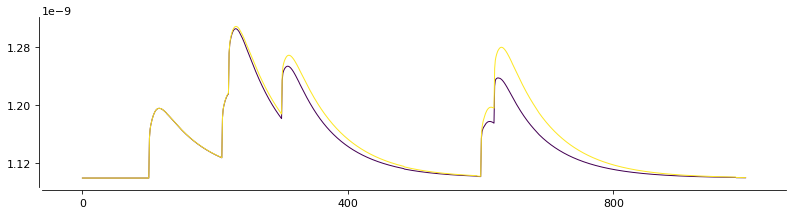

In [327]:
# protocol setup


# with Zinc modulation

# 

ge.plot(Y=[sim['Itot'], sim_no_Zn['Itot']], fig_args={'figsize':(2.5,2)})

In [321]:
params['Q_Zn']

5e-09